<a href="https://colab.research.google.com/github/josware/data-science-intermediate/blob/main/DS_AI_APPS_Intermediate_3_Kaggle_Dep_of_Justice_Press_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Department of Justice 2009-2018 Press Releases


## Topic Modeling - Problem Definition

### Long description:

**The ability to work with text is essential**

* You will build a clustering algorithm that finds similar topics across 
documents - this is called **topic modelling**.

**TF-IDF?**
An algorithm does not work with text directly but needs to translate it to numbers first. This is typically done by so called **TF-IDF transformation**. 
Sometimes you already know classes to which documents belong. 
i.e. Think of an email as a document and spam or non-spam as classes. In that case, you can build a nice Naive Bayes model on top of a TF-IDF matrix.

**Clustering - unsupervised learning**
However, in this project we will focus on the **unsupervised situation** when the **classes are not known** and they need to be discovered via **clustering**. 

**NMF / matrix factorisatio**
Clustering here can be done via the matrix factorisation technique or NMF - see this blog post for more details. The task of the project is to discover topics of department of justice press releases.
https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/

### tl;dr:

Quick Summary:
* **Topic modelling** - Build a clustering algorithm that finds similar topics across 
documents.
* **TF-IDF transformation & Bayes** Not used as we don't know the classess (unsupervised problem).
* **NMF** or Matrix Factorisation, is what we will be using.


**Task:**
Discover topics of department of justice press releases. 

https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/

## Installing Requirements

### How to make a requirements.txt

One way
```
!pip freeze > requirements.txt
```

But we used text editor and manually added, format is as follow:
```
# Simple (latest version)
package # i.e surprise

# Specific version
package==version # i.e. surprise=1.1.1

# At least version...
package>=version # i.e surprise>=1.1.1

```

In this particular case we are using the --install-option as described in:

https://pip.pypa.io/en/stable/cli/pip_install/#install-install-option
```
# --install-option (arguments for Kaggle)
kaggle --install-option="--upgrade --force-reinstall --no-deps"
```
More info in:

https://pip.pypa.io/en/stable/reference/requirements-file-format/

### How to install a requirements.txt

We are using the following command:
```
!pip install -r requirements.txt
```


In [ ]:
drivePath = "drive/MyDrive/DS/AIAPPS/Intermediate"
requirementsFile = "requirements-case3-DepOfJustice.txt"


!pip install -r $drivePath/$requirementsFile


/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_file.py:187: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options, line.opts)


### importing libraries


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split


## Data

### Data Description
This is a historical dataset containing 13,087 press releases from the Department of Justice's (DOJ) website https://www.justice.gov/news. The DOJ typically publishes several releases per day and this dataset spans from 2009 to July 2018. The releases contain information such as outcomes of criminal cases, notable actions taken against felons, or other updates about the current administration. 

This dataset only includes releases categorized as "Press release" and does not contain those which have been labeled as "Speeches". Some releases are tagged with topics or related agencies.

The original Python code to scrape the data can be found on GitHub at https://github.com/jbencina/dojreleases

### Files description (content of combined.json)

The contents are stored as newline delimited JSON records with the following fields:

* id: Press release number (can be missing if included in contents)
* title: Title of release
* contents: Text of release
* date: Posted date
* topics: Array of topic tags (if any provided)
* components: Array of agencies & departments (if any provided)

### Inspiration
The data provides an opportunity for analysis including:

* How have the reported topics changed over the years / administrations?
* What words tend occur frequently together?
* How can documents be clustered using the content of the releases?
* Can a predictive text model be trained off the supplied topics?
- Use a tool like Spacy to handle named entities in the releases (names, locations, etc.)

https://spacy.io/

### Acknowledgements
All data was sourced from https://www.justice.gov/news

### Getting Data Set from Kaggle

In [ ]:
#!mkdir ~/.kaggle
! cp drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#if in below block you get 401 probably access token expired
#visit https://www.kaggle.com/josuegomez/account click expire download to your dis and upload a new one to drive

#### Kaggle's API doc

https://www.kaggle.com/docs/api

In [ ]:
! kaggle competitions list -s "Department of Justice 2009-2018"

No competitions found


In [ ]:
! kaggle competitions download -c 'Department of Justice 2009-2018'

404 - Not Found


In [ ]:
! kaggle datasets list -s "Department of Justice 2009-2018"

ref                                                     title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
jbencina/department-of-justice-20092018-press-releases  Department of Justice 2009-2018 Press Releases  14MB  2018-07-29 19:08:15           1405         36  0.875            


In [ ]:
! kaggle datasets download  'jbencina/department-of-justice-20092018-press-releases'

 65% 9.00M/13.8M [00:00<00:00, 25.5MB/s]
100% 13.8M/13.8M [00:00<00:00, 37.5MB/s]


In [ ]:
!ls

department-of-justice-20092018-press-releases.zip  drive  sample_data


In [ ]:
!unzip department-of-justice-20092018-press-releases.zip

Archive:  department-of-justice-20092018-press-releases.zip
  inflating: combined.json           


In [ ]:
!ls


combined.json					   drive
department-of-justice-20092018-press-releases.zip  sample_data


In [ ]:
#!rm department-of-justice-20092018-press-releases.zip

!ls

combined.json					   drive
department-of-justice-20092018-press-releases.zip  sample_data


### Loading Data

In [ ]:
df = pd.read_json("combined.json",
                  lines=True,
                  convert_dates=True
                  )


#pandas.read_json(path_or_buf=None, orient=None, typ='frame', dtype=None, 
#                 convert_axes=None, convert_dates=True, keep_default_dates=True, 
#                 numpy=False, precise_float=False, date_unit=None, encoding=None, 
#                 encoding_errors='strict', lines=False, chunksize=None, 
#                 compression='infer', nrows=None, storage_options=None)
#
# https://pandas.pydata.org/docs/reference/api/pandas.read_json.html

In [ ]:
#confiming train df is loaded
df.head()

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


### EDA

#### Data quality - missing values?

In [ ]:
df.shape

(13087, 6)

In [ ]:
df.describe()

,id,title,contents,date,topics,components
count,12810,13087,13087,13087,13087,13087
unique,12672,12887,13080,2400,253,810
top,13-526,Northern California Real Estate Investor Agree...,"WASHINGTON – ING Bank N.V., a financial inst...",2018-04-13T00:00:00-04:00,[],[Criminal Division]
freq,3,8,2,20,8399,2680


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13087 entries, 0 to 13086
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12810 non-null  object
 1   title       13087 non-null  object
 2   contents    13087 non-null  object
 3   date        13087 non-null  object
 4   topics      13087 non-null  object
 5   components  13087 non-null  object
dtypes: object(6)
memory usage: 613.6+ KB


In [ ]:
df.isna().sum()

id            277
title           0
contents        0
date            0
topics          0
components      0
dtype: int64

In [ ]:
df.isnull().sum()

id            277
title           0
contents        0
date            0
topics          0
components      0
dtype: int64

#### Correlation

In [ ]:
df.corr()

""


In [ ]:
## Seems like text doesn't have much correlation XD

### Feature Engineering

In [ ]:
#! mkdir test
#! mkdir train
#! mkdir sample_submission

# Sandbox

LDA Implementation
The complete code is available as a Jupyter Notebook on GitHub
Loading data

*   Data cleaning
*   Exploratory analysis
*   Preparing data for LDA analysis
*   LDA model training
*   Analyzing LDA model results

https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb

In [ ]:
papers = df

In [ ]:
# Load the regular expression library
import re
# Remove punctuation
#papers['paper_text_processed'] = \
papers['contents'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#papers['paper_text_processed'] = \
papers['contents'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['contents'].head()

0    PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...
1      WASHINGTON – North Carolina’s Waccamaw River...
2          BOSTON– A $1-million settlement has been...
3      WASHINGTON—A federal grand jury in Las Vegas...
4    The U.S. Department of Justice, the U.S. Envir...
Name: contents, dtype: object

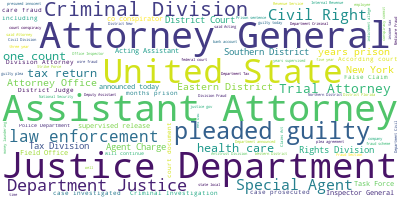

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['contents'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#removing stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.contents.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['portland', 'oregon', 'mohamed', 'osman', 'mohamud', 'convicted', 'attempting', 'weapon', 'mass', 'destruction', 'explosives', 'connection', 'plot', 'detonate', 'vehicle', 'bomb', 'annual', 'christmas', 'tree', 'lighting', 'ceremony', 'portland', 'sentenced', 'today', 'serve', 'years', 'prison', 'followed', 'lifetime', 'term']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 12), (12, 9), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 1), (29, 3)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"department" + 0.010*"justice" + 0.008*"attorney" + 0.007*"court" + '
  '0.007*"district" + 0.006*"today" + 0.005*"said" + 0.005*"division" + '
  '0.005*"settlement" + 0.005*"general"'),
 (1,
  '0.014*"attorney" + 0.012*"district" + 0.009*"department" + 0.008*"division" '
  '+ 0.008*"case" + 0.007*"justice" + 0.007*"federal" + 0.006*"assistant" + '
  '0.006*"prison" + 0.006*"guilty"'),
 (2,
  '0.011*"department" + 0.011*"attorney" + 0.010*"justice" + 0.007*"general" + '
  '0.006*"federal" + 0.006*"office" + 0.006*"enforcement" + 0.006*"district" + '
  '0.005*"division" + 0.005*"today"'),
 (3,
  '0.026*"tax" + 0.012*"irs" + 0.008*"division" + 0.008*"attorney" + '
  '0.008*"accounts" + 0.007*"department" + 0.007*"bank" + 0.007*"returns" + '
  '0.007*"income" + 0.005*"criminal"'),
 (4,
  '0.010*"attorney" + 0.008*"office" + 0.007*"false" + 0.007*"district" + '
  '0.007*"department" + 0.007*"general" + 0.006*"division" + 0.006*"fraud" + '
  '0.006*"justice" + 0.006*"assistant

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=160b7978c545246e42f547ab703ede92adffbab805e67229d904ec3ba0fe3e09
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
!touch ldavis_prepared_10
!ls


combined.json					   ldavis_prepared_10
department-of-justice-20092018-press-releases.zip  sample_data
drive


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import os

import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
#LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ str(num_topics))
LDAvis_data_filepath = 'ldavis_prepared_' + str(num_topics)
#try:
#  os.mkdir(LDAvis_data_filepath)
#except:
#  print("An exception occurred")
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
#pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_10.html')
LDAvis_prepared


An exception occurred


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.068617  0.005978       1        1  13.909957
1     -0.016466  0.077069       2        1  12.718849
0      0.056454 -0.046578       3        1  11.422187
3     -0.104358 -0.084578       4        1  11.167627
8     -0.083420  0.012761       5        1  11.032893
5      0.021493  0.002333       6        1   9.953233
9      0.048573 -0.039616       7        1   9.378300
7     -0.033501  0.089247       8        1   8.266331
6      0.049442  0.008474       9        1   6.434739
4     -0.006837 -0.025090      10        1   5.715885, topic_info=          Term          Freq         Total Category  logprob  loglift
2719       tax  22308.000000  22308.000000  Default  30.0000  30.0000
2949  medicare   8391.000000   8391.000000  Default  29.0000  29.0000
469     health  11263.000000  11263.000000  Default  28.0000  28.0000
2098       irs   9927.000000   9927.000000  Default  27.0000  27.0000
1830     fraud  19655.000000  19655.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
297       said    957.986000  16772.397870  Topic10  -5.6095  -0.0007
1639     civil    886.504363  14444.280786  Topic10  -5.6871   0.0712
14        also    915.503110  17329.800014  Topic10  -5.6549  -0.0788
372      years    807.962878  15145.243320  Topic10  -5.7798  -0.0690
79       court    808.284826  17280.211675  Topic10  -5.7794  -0.2005

[995 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
19449      1  0.018450       abc
19449      2  0.009225       abc
19449      3  0.009225       abc
19449      4  0.009225       abc
19449      5  0.009225       abc
...      ...       ...       ...
22765      6  0.011449    zurich
22765      7  0.005724    zurich
22765      8  0.005724    zurich
22765     10  0.017173    zurich
54176      4  0.984848  zweiplus

[4424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 9, 6, 10, 8, 7, 5])

## References

This work is product of research and was based and/or inspired from below sources:


1.   https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/
2.   https://pip.pypa.io/en/stable/reference/requirements-file-format/
3.   https://spacy.io/
4.   https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
5.   https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb
6.   Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
7.   Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
8.   Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
9.   A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf

